# Přísnost známkování na PISA 2018

Vzorek:
- omez PISA 18 pouze na 9. ročníky ZŠ (tzn. vyřaď i víceletá gymnázia a 7. a 8. ročníky)
- podívej se na přísnost v různých předmětech (asi hlavně matematika, tam je nejspíš kurikulum nejvíce podobné)

## Načtení dat

In [2]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

In [3]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [4]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [5]:
sch18_vars = sch18[['CNTSCHID', 'SC013Q01TA', 'SCHSIZE']].copy()
sch18_vars['sch_public'] = np.where(sch18_vars['SC013Q01TA'].isnull(), pd.NA, sch18_vars['SC013Q01TA'] == 1)
sch18_vars['sch_pupils'] = sch18_vars['SCHSIZE']
sch18_vars = sch18_vars.drop(columns=['SC013Q01TA', 'SCHSIZE'])

## Kraje

In [1]:
# kodovani od Radka Blazka pro PISA 2015 - sedi to i na 2018? -- ano, zjevne to sedi
strat_id = {
    1 : 'PHA',
    2 : 'STC',
    3 : 'PLK',
    4 : 'KVK',
    5 : 'ULK',
    6 : 'JHC',
    7 : 'LBK',
    8 : 'HKK',
    9 : 'PAK',
    10 : 'VYS',
    11 : 'JHM',
    12 : 'OLK',
    13 : 'MSK',
    14 : 'ZLK'
}

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [6]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
from unidecode import unidecode

In [7]:
# get the response in the form of html
wikiurl="https://cs.wikipedia.org/wiki/Kraje_v_%C4%8Cesku"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

regions_raw = pd.DataFrame(pd.read_html(str(indiatable))[0])

200


In [8]:
regions = regions_raw.rename(columns={'Název kraje (kraj)': 'kraj', 'Zkratka ČSÚ': 'zkratka'})[['kraj', 'zkratka']].iloc[:-1].copy()
regions['zkratka'] = regions['zkratka'].apply(unidecode)

In [9]:
# get the response in the form of html
wikiurl="https://cs.wikipedia.org/wiki/CZ-NUTS"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

nuts_raw = pd.DataFrame(pd.read_html(str(indiatable))[0])

200


In [10]:
nuts3 = pd.merge(regions, nuts_raw.iloc[:-1]['NUTS 3'].rename(columns={'kód': 'kod'}))

In [11]:
nuts3

,kraj,zkratka,kod
0,Hlavní město Praha,PHA,CZ010
1,Středočeský kraj,STC,CZ020
2,Jihočeský kraj,JHC,CZ031
3,Plzeňský kraj,PLK,CZ032
4,Karlovarský kraj,KVK,CZ041
5,Ústecký kraj,ULK,CZ042
6,Liberecký kraj,LBK,CZ051
7,Královéhradecký kraj,HKK,CZ052
8,Pardubický kraj,PAK,CZ053
9,Kraj Vysočina,VYS,CZ063


## Příprava dat

Známky jsou ve sloupcích:
- ST800C01HA_CZ -- ST800C07HA_CZ
- odpovědi jsou 1-6, kde 6 = Předmět nemáme, jinak je to přímo známka
- předměty:
    - 01 = Matematika
    - 02 = Český jazyk
    - 03 = Cizí jazyk
    - 04 = Fyzika
    - 05 = Chemie
    - 06 = Přírodopis / biologie
    - 07 = Zeměpis


In [12]:
col_math = [f'PV{i}MATH' for i in range(1,11)]
col_read = [f'PV{i}READ' for i in range(1,11)]
col_scie = [f'PV{i}SCIE' for i in range(1,11)]
col_w = 'W_FSTUWT'
col_str = 'STRATUM'
col_sch = 'CNTSCHID'
col_gg = 'ST001D01T'
col_gr = [f'ST800C0{i}HA_CZ' for i in range(1, 8)]
col_escs = 'ESCS'
col_sex = 'ST004D01T'
col_all = [col_sch, col_str, col_w, col_gg, col_escs, col_sex] + col_math + col_read + col_scie + col_gr

In [13]:
df18 = stu18[col_all].copy()

In [14]:
df18 = pd.merge(df18, sch18_vars)

In [15]:
df18['stratum_label'] = df18['STRATUM'].apply(lambda x: stu18_meta.variable_value_labels['STRATUM'][x])

In [16]:
df18['sch_type'] = \
    np.where(df18['stratum_label'].str.contains('Basic'), 'zs',
        np.where(df18['stratum_label'].str.contains('6-8yrGym'), 'gym',
            np.where(df18['stratum_label'].str.contains('4yr Gym'), 'gym4',
                np.where(df18['stratum_label'].str.contains('Voc-Tech-Conservatory with maturate'), 'sos',
                    np.where(df18['stratum_label'].str.contains('Voc-Tech Secondary without maturate'), 'sou',
                        np.where(df18['stratum_label'].str.contains('Special & practical'), 'spec', 'undisclosed'))))))

In [17]:
def parse_region(x):
    res = re.search('Region([0-9]+)$', x)
    if res is not None:
        return int(res.group(1))
    else:
        return 0
df18['reg_id'] = df18['stratum_label'].apply(parse_region)
df18['reg'] = df18['reg_id'].apply(lambda x: strat_id[x] if x else None)

In [18]:
df18['math'] = df18[col_math].mean(axis=1)
df18['read'] = df18[col_read].mean(axis=1)
df18['scie'] = df18[col_scie].mean(axis=1)
df18['w'] = df18[col_w]
df18['sch_id'] = df18[col_sch]
df18['gr'] = df18[col_gg]
df18['girl'] = df18[col_sex] == 1
df18['escs'] = df18['ESCS']

In [19]:
df18['sch_size'] = pd.cut(df18['sch_pupils'], [0, 250, 400, 550, np.inf])

In [20]:
col_start = ['sch_id', 'sch_type', 'sch_public', 'sch_size', 'reg_id', 'reg', 'gr', 'girl', 'w', 'math', 'read', 'scie', 'stratum_label', 'escs']
df18 = df18[col_start + col_all].copy()

In [21]:
df18.shape

(7019, 57)

In [22]:
df18 = df18[(df18['gr'] == 9) & (df18['sch_type'] == 'zs')].copy()

In [23]:
df18.shape

(2187, 57)

## Známky

Podívej se na korelace

In [41]:
# fix missing grades
for c in col_gr:
    df18[c] = df18[c].replace(6, np.nan)

In [44]:
df18[['math', 'read', 'scie'] + col_gr].corr()

,math,read,scie,ST800C01HA_CZ,ST800C02HA_CZ,ST800C03HA_CZ,ST800C04HA_CZ,ST800C05HA_CZ,ST800C06HA_CZ,ST800C07HA_CZ
math,1.000000,0.804609,0.863591,-0.489968,-0.452952,-0.474610,-0.489642,-0.458117,-0.448932,-0.420460
read,0.804609,1.000000,0.855447,-0.415808,-0.473451,-0.479062,-0.452703,-0.427836,-0.445156,-0.403519
scie,0.863591,0.855447,1.000000,-0.440089,-0.396766,-0.431850,-0.437816,-0.407465,-0.410360,-0.365597
ST800C01HA_CZ,-0.489968,-0.415808,-0.440089,1.000000,0.554519,0.465548,0.536812,0.545945,0.480864,0.460533
ST800C02HA_CZ,-0.452952,-0.473451,-0.396766,0.554519,1.000000,0.603279,0.614796,0.628912,0.639087,0.592969
ST800C03HA_CZ,-0.474610,-0.479062,-0.431850,0.465548,0.603279,1.000000,0.564208,0.559630,0.560125,0.525996
ST800C04HA_CZ,-0.489642,-0.452703,-0.437816,0.536812,0.614796,0.564208,1.000000,0.668179,0.646420,0.594531
ST800C05HA_CZ,-0.458117,-0.427836,-0.407465,0.545945,0.628912,0.559630,0.668179,1.000000,0.682652,0.600562
ST800C06HA_CZ,-0.448932,-0.445156,-0.410360,0.480864,0.639087,0.560125,0.646420,0.682652,1.000000,0.680532
ST800C07HA_CZ,-0.420460,-0.403519,-0.365597,0.460533,0.592969,0.525996,0.594531,0.600562,0.680532,1.000000


In [49]:
subjects = ['matematika', 'ceskyjazyk', 'cizijazyk', 'fyzika', 'chemie', 'prirodopis', 'zemepis']
for i in range(7):
    df18[f'gr_{subjects[i]}'] = df18[f'ST800C0{i+1}HA_CZ']

In [61]:
reg_math = smf.wls('math ~ gr_matematika', df18[['math', 'gr_matematika']], weights=df18['w']).fit()

In [62]:
reg_math.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   math   R-squared:                       0.229
Model:                            WLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     558.4
Date:                Thu, 17 Mar 2022   Prob (F-statistic):          2.63e-108
Time:                        20:18:30   Log-Likelihood:                -10588.
No. Observations:                1881   AIC:                         2.118e+04
Df Residuals:                    1879   BIC:                         2.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       551.4250      3.447    159.977      0.000     544.665     558.185
gr_matematika   -23.2638      0.984    -23.631      0.000     -25.195     -21.333
==============================================================================
Omnibus:                       20.029   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.076
Skew:                          -0.172   Prob(JB):                     5.92e-06
Kurtosis:                       3.434   Cond. No.                         8.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
reg_math.rsquared

0.22909716511500133

In [66]:
reg_read = smf.wls('read ~ gr_ceskyjazyk', df18[['read', 'gr_ceskyjazyk']], weights=df18['w']).fit()

In [154]:
reg_scie = smf.wls('scie ~ gr_fyzika + gr_chemie + gr_prirodopis', df18[['scie', 'gr_fyzika', 'gr_chemie', 'gr_prirodopis']], weights=df18['w']).fit()

In [67]:
reg_read.rsquared

0.21630383087162974

In [104]:
reg_scie.rsquared

0.19636632276505095

In [155]:
df18['pred_math'] = reg_math.predict(df18)
df18['resid_math'] = df18['math'] - df18['pred_math']
df18['pred_read'] = reg_read.predict(df18)
df18['resid_read'] = df18['read'] - df18['pred_read']
df18['pred_scie'] = reg_scie.predict(df18)
df18['resid_scie'] = df18['scie'] - df18['pred_scie']

In [156]:
# wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'].values[~np.isnan(x)])
def wm(x, weights=None):    
    res = pd.Series()
    for c in x.columns:
        if weights is None or c != x:
            res[c] = 
        

def wm(x):
    x = x[~np.isnan(x)]
    return np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
res = df18.groupby(['reg'], dropna=False)[['resid_math', 'resid_read', 'resid_scie', 'math', 'read', 'scie']].agg(wm).reset_index()

In [157]:
res

,reg,resid_math,resid_read,resid_scie,math,read,scie
0,HKK,-13.293154,-16.804470,-1.154760,461.116016,443.063196,460.967522
1,JHC,5.809357,13.897815,5.203785,484.291486,477.198560,482.902579
2,JHM,-5.419375,-12.698789,-12.164342,473.936857,457.503427,467.071923
3,KVK,-0.317318,-11.552534,-13.784902,464.762466,449.398936,462.059489
4,LBK,5.380891,14.435538,7.396615,485.712619,475.120070,483.733410
5,MSK,-8.317895,-12.033049,-12.991550,470.524797,454.131099,463.090538
6,OLK,-6.295504,4.667394,-2.818090,475.332087,470.219602,473.391387
7,PAK,8.256270,-4.972135,-1.916913,481.056228,458.555478,473.130175
8,PHA,9.197187,7.251497,14.536733,487.922531,475.067368,493.589913
9,PLK,15.028436,16.318412,14.995523,484.872376,474.848106,483.230223


In [97]:
plt.rcParams['figure.figsize'] = 10, 6

Text(0.5, 1.0, 'Přísnost známkování v matematice vs PISA skóry pro jednotlivé kraje')

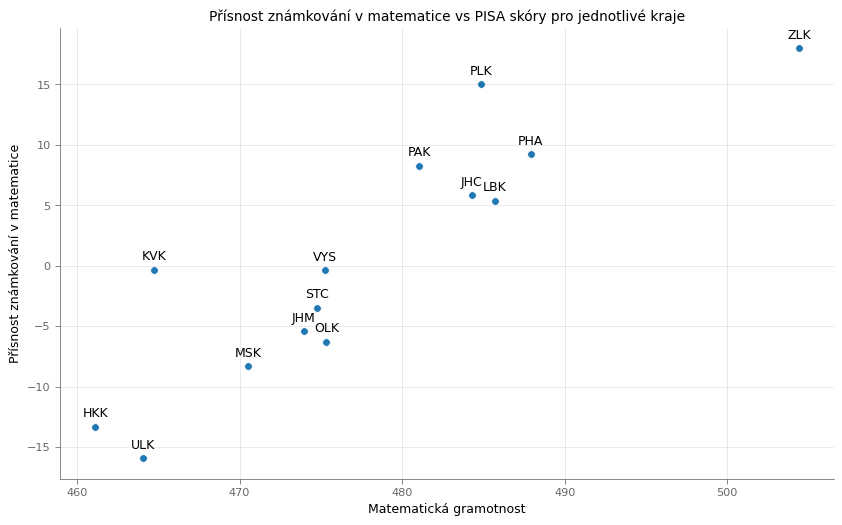

In [100]:
ax = sns.scatterplot(data=res, x='math', y='resid_math')
for _, row in res.iterrows():
    ax.text(row['math'], row['resid_math'] + 0.8, row['reg'], ha='center')
ax.set(xlabel='Matematická gramotnost', ylabel='Přísnost známkování v matematice')
ax.set_title('Přísnost známkování v matematice vs PISA skóry pro jednotlivé kraje')

Text(0.5, 1.0, 'Přísnost známkování v ČJ vs PISA skóry pro jednotlivé kraje')

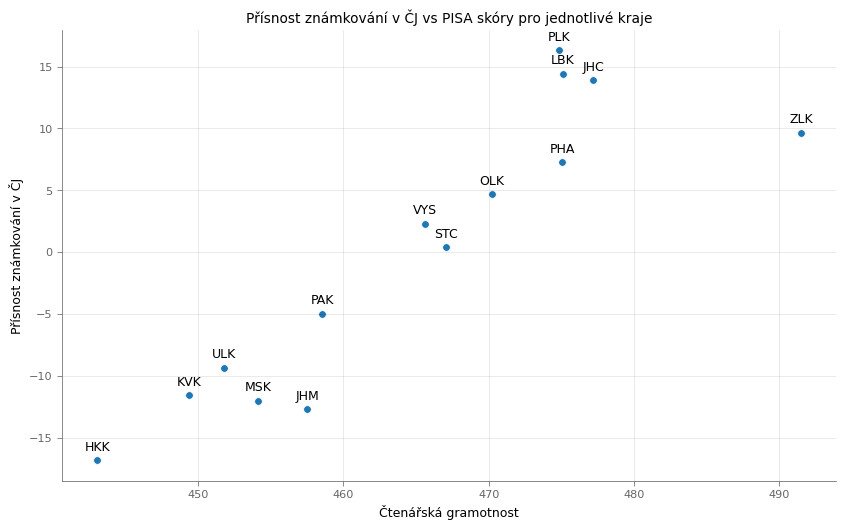

In [99]:
ax = sns.scatterplot(data=res, x='read', y='resid_read')
for _, row in res.iterrows():
    ax.text(row['read'], row['resid_read'] + 0.8, row['reg'], ha='center')
ax.set(xlabel='Čtenářská gramotnost', ylabel='Přísnost známkování v ČJ')
ax.set_title('Přísnost známkování v ČJ vs PISA skóry pro jednotlivé kraje')

Text(0.5, 1.0, 'Přísnost známkování ve fyzice, chemii a přírodopisu vs PISA skóry pro jednotlivé kraje')

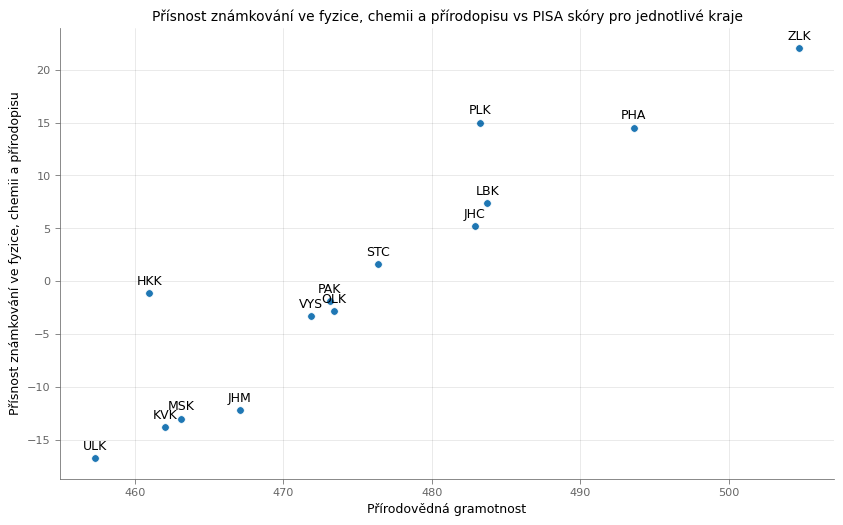

In [158]:
ax = sns.scatterplot(data=res, x='scie', y='resid_scie')
for _, row in res.iterrows():
    ax.text(row['scie'], row['resid_scie'] + 0.8, row['reg'], ha='center')
ax.set(xlabel='Přírodovědná gramotnost', ylabel='Přísnost známkování ve fyzice, chemii a přírodopisu')
ax.set_title('Přísnost známkování ve fyzice, chemii a přírodopisu vs PISA skóry pro jednotlivé kraje')

## Geoanalýza

In [108]:
import folium
import geojson
import geopandas as gpd

In [159]:
gdf = gpd.read_file('misc/kraje-simple.json')

In [112]:
gdf.head()

,id,KOD,NAZEV,REGS_KOD,NUTS3_KOD,geometry
0,19,19,Hlavní město Praha,19,CZ010,"POLYGON ((14.30240 50.12997, 14.30240 50.13000..."
1,27,27,Středočeský kraj,27,CZ020,"POLYGON ((14.48652 50.50506, 14.48807 50.50378..."
2,35,35,Jihočeský kraj,35,CZ031,"POLYGON ((14.93205 49.54945, 14.92850 49.54597..."
3,43,43,Plzeňský kraj,35,CZ032,"POLYGON ((13.76576 49.51404, 13.76249 49.51432..."
4,51,51,Karlovarský kraj,43,CZ041,"POLYGON ((13.30183 50.09945, 13.29725 50.09633..."


In [160]:
gdf = pd.merge(gdf, nuts3.rename(columns={'zkratka': 'reg', 'kod': 'NUTS3_KOD'})[['reg', 'NUTS3_KOD']])

In [161]:
gdf = pd.merge(gdf, res)

In [162]:
gdf['resid_math_inv'] = -gdf['resid_math']

In [125]:
map0 = folium.Map(location=[49.8037633, 15.4749126], zoom_start=7, tiles='https://mapserver.mapy.cz/base-m/{z}-{x}-{y}', attr='<a href="https://www.mapy.cz" target="_blank">mapy.cz</a> attribution')

folium.Choropleth(geo_data=gdf, name='Choropleth', data=gdf, columns=['NUTS3_KOD', 'resid_math_inv'], key_on='feature.properties.NUTS3_KOD', fill_color='RdYlGn', fill_opacity=0.7, line_opacity=0.5, legend_name='Czechia').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAZEV', 'resid_math'],
        aliases=['Kraj', 'Přísnost'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

map0

[Text(0.5, 46.764633365221655, 'longitude')]

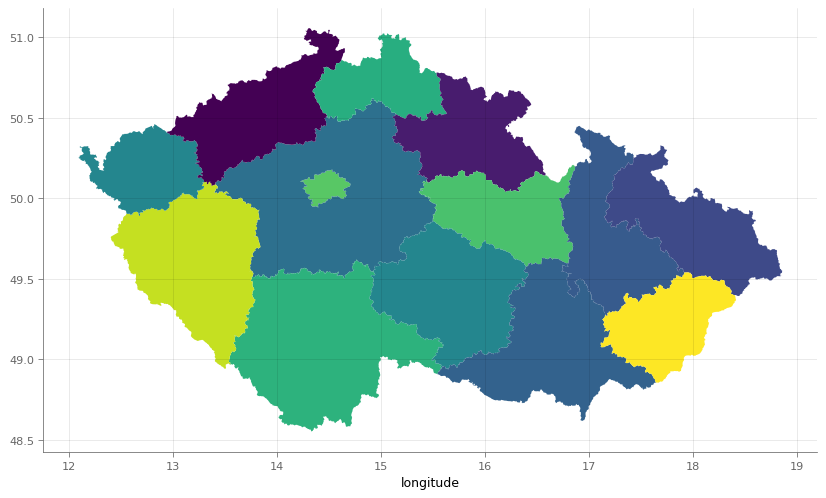

In [128]:
ax = gdf.plot(column='resid_math')
ax.set(xlabel='longitude')

In [137]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="myGeocoder")

In [139]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
def get_point(kraj):
    loc = geocode(f'{kraj}, Česko')
    if loc:
        return tuple(loc.point)

In [164]:
gdf['point'] = gdf['NAZEV'].apply(get_point)

In [165]:
gdf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(gdf['point'].tolist(), index=gdf.index)

In [142]:
gdf

,id,KOD,NAZEV,REGS_KOD,NUTS3_KOD,geometry,reg,resid_math,resid_read,resid_scie,math,read,scie,resid_math_inv,point,latitude,longitude,altitude
0,19,19,Hlavní město Praha,19,CZ010,"POLYGON ((14.30240 50.12997, 14.30240 50.13000...",PHA,9.197187,7.251497,14.429116,487.922531,475.067368,493.589913,-9.197187,"(50.0874654, 14.4212535, 0.0)",50.087465,14.421254,0.0
1,27,27,Středočeský kraj,27,CZ020,"POLYGON ((14.48652 50.50506, 14.48807 50.50378...",STC,-3.480506,0.396587,0.089781,474.788059,467.097677,476.349243,3.480506,"(50.0601579, 13.83074794209991, 0.0)",50.060158,13.830748,0.0
2,35,35,Jihočeský kraj,35,CZ031,"POLYGON ((14.93205 49.54945, 14.92850 49.54597...",JHC,5.809357,13.897815,5.924538,484.291486,477.198560,482.902579,-5.809357,"(49.0864548, 14.600172741470452, 0.0)",49.086455,14.600173,0.0
3,43,43,Plzeňský kraj,35,CZ032,"POLYGON ((13.76576 49.51404, 13.76249 49.51432...",PLK,15.028436,16.318412,18.543637,484.872376,474.848106,483.230223,-15.028436,"(49.522810199999995, 13.206311785137638, 0.0)",49.522810,13.206312,0.0
4,51,51,Karlovarský kraj,43,CZ041,"POLYGON ((13.30183 50.09945, 13.29725 50.09633...",KVK,-0.317318,-11.552534,-10.793912,464.762466,449.398936,462.059489,0.317318,"(50.1753532, 12.806086309968043, 0.0)",50.175353,12.806086,0.0
5,60,60,Ústecký kraj,43,CZ042,"POLYGON ((12.94828 50.40482, 12.94770 50.40725...",ULK,-15.905416,-9.337015,-18.841032,464.038918,451.802208,457.330016,15.905416,"(50.5663266, 13.820670539566608, 0.0)",50.566327,13.820671,0.0
6,78,78,Liberecký kraj,51,CZ051,"POLYGON ((15.53532 50.77942, 15.53577 50.77467...",LBK,5.380891,14.435538,7.432077,485.712619,475.120070,483.733410,-5.380891,"(50.747603999999995, 14.990310290688765, 0.0)",50.747604,14.990310,0.0
7,86,86,Královéhradecký kraj,51,CZ052,"POLYGON ((15.43745 50.10994, 15.43831 50.11210...",HKK,-13.293154,-16.804470,-3.391345,461.116016,443.063196,460.967522,13.293154,"(50.40939265, 15.68500539430977, 0.0)",50.409393,15.685005,0.0
8,94,94,Pardubický kraj,51,CZ053,"POLYGON ((16.39208 49.58015, 16.39037 49.58096...",PAK,8.256270,-4.972135,-1.035768,481.056228,458.555478,473.130175,-8.256270,"(49.889818950000006, 16.128325371948733, 0.0)",49.889819,16.128325,0.0
9,108,108,Kraj Vysočina,60,CZ063,"POLYGON ((14.93205 49.54945, 14.93240 49.55241...",VYS,-0.376566,2.282084,-3.342828,475.271757,465.601909,471.845390,0.376566,"(49.399409750000004, 15.570468337643561, 0.0)",49.399410,15.570468,0.0


(11.752241013076535, 19.197704540256108, 48.42672074084285, 51.18092472650973)

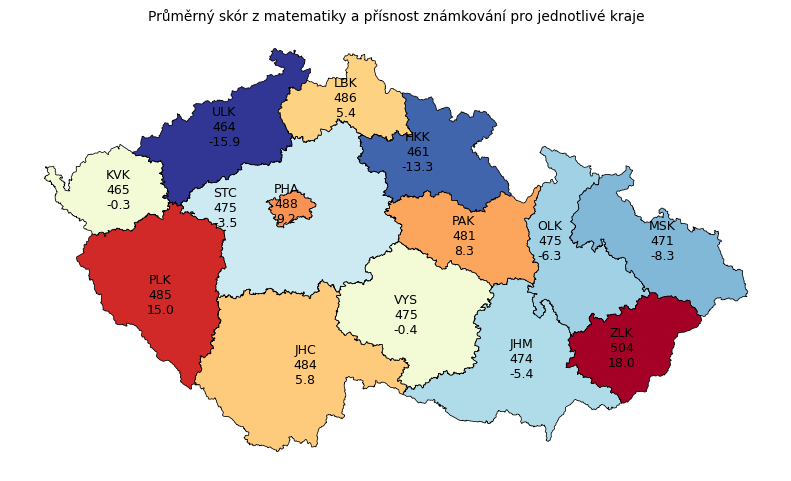

In [171]:
ax = gdf.plot(column='resid_math', cmap='RdYlBu_r', edgecolor='black', linewidth=0.6)
for _, row in gdf.iterrows():
    label = f'{row.reg}\n{row.math:.0f}\n{row.resid_math:.1f}'
    ax.text(row['longitude'], row['latitude'], label, ha='center', va='center')
ax.set_title('Průměrný skór z matematiky a přísnost známkování pro jednotlivé kraje')
plt.axis('off')

(11.752241013076535, 19.197704540256108, 48.42672074084285, 51.18092472650973)

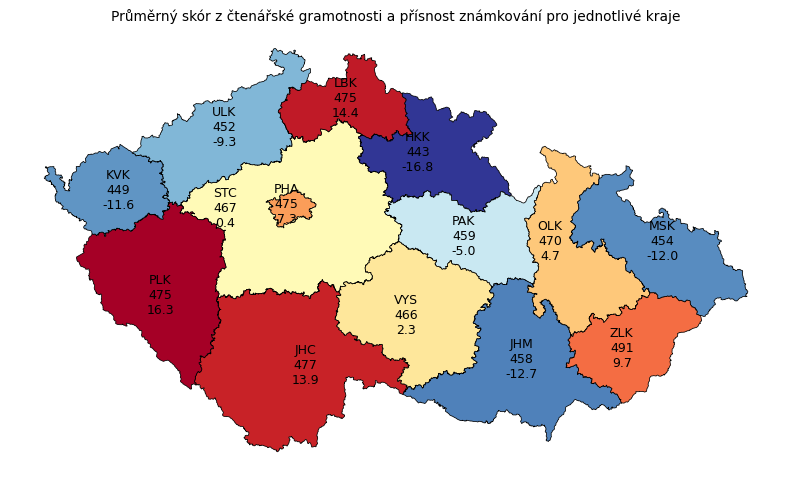

In [172]:
ax = gdf.plot(column='resid_read', cmap='RdYlBu_r', edgecolor='black', linewidth=0.6)
for _, row in gdf.iterrows():
    label = f'{row.reg}\n{row.read:.0f}\n{row.resid_read:.1f}'
    ax.text(row['longitude'], row['latitude'], label, ha='center', va='center')
ax.set_title('Průměrný skór z čtenářské gramotnosti a přísnost známkování pro jednotlivé kraje')
plt.axis('off')

(11.752241013076535, 19.197704540256108, 48.42672074084285, 51.18092472650973)

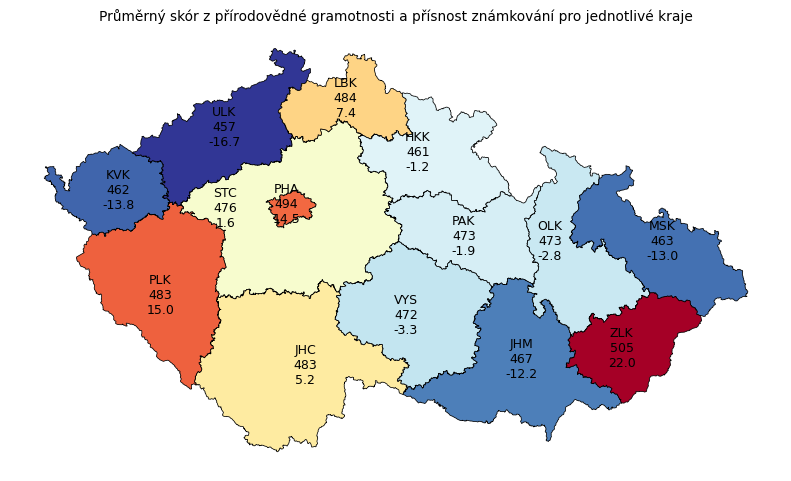

In [173]:
ax = gdf.plot(column='resid_scie', cmap='RdYlBu_r', edgecolor='black', linewidth=0.6)
for _, row in gdf.iterrows():
    label = f'{row.reg}\n{row.scie:.0f}\n{row.resid_scie:.1f}'
    ax.text(row['longitude'], row['latitude'], label, ha='center', va='center')
ax.set_title('Průměrný skór z přírodovědné gramotnosti a přísnost známkování pro jednotlivé kraje')
plt.axis('off')

In [131]:
locator.geocode('Rybnická 93, Brno, 63400, Czechia')

Location(93/31, Rybnická, Pisárky, Nový Lískovec, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, 63400, Česko, (49.1832583, 16.5636024, 0.0))

In [134]:
loc = locator.geocode('Jihomoravský kraj, Česko')

49.1249179

In [87]:
df18_ = df18.dropna(subset=['resid_math', 'resid_read'])
wm = lambda x: np.average(x, weights=df18_.loc[x.index, 'w'])
res = df18_.groupby(['reg'], dropna=False)[['resid_math', 'resid_read', 'math', 'read']].agg(wm).reset_index()

In [88]:
res

,reg,resid_math,resid_read,math,read
0,HKK,-13.293154,-16.804470,465.119881,449.487828
1,JHC,6.266717,13.897815,484.612523,479.367918
2,JHM,-5.419375,-11.848845,475.787682,461.478117
3,KVK,-0.317318,-11.552534,468.914612,456.472677
4,LBK,5.380891,14.435538,486.160571,477.616482
5,MSK,-8.317895,-12.033049,471.147081,457.053634
6,OLK,-5.498523,4.667394,475.673192,472.768252
7,PAK,8.256270,-4.972135,478.814465,459.928431
8,PHA,9.197187,7.251497,491.996655,478.186614
9,PLK,15.028436,16.318412,485.450019,476.236791


In [42]:
[df18[c].value_counts(dropna=False) for c in col_gr]

[2.0    618
 5.0    555
 4.0    358
 1.0    329
 NaN    306
 3.0     21
 Name: ST800C01HA_CZ, dtype: int64,
 2.0    693
 3.0    570
 1.0    383
 NaN    308
 4.0    219
 5.0     14
 Name: ST800C02HA_CZ, dtype: int64,
 1.0    759
 2.0    592
 3.0    403
 NaN    307
 4.0    116
 5.0     10
 Name: ST800C03HA_CZ, dtype: int64,
 2.0    712
 1.0    546
 3.0    449
 NaN    305
 4.0    163
 5.0     12
 Name: ST800C04HA_CZ, dtype: int64,
 2.0    616
 1.0    590
 3.0    470
 NaN    307
 4.0    187
 5.0     17
 Name: ST800C05HA_CZ, dtype: int64,
 1.0    734
 2.0    620
 3.0    401
 NaN    304
 4.0    116
 5.0     12
 Name: ST800C06HA_CZ, dtype: int64,
 1.0    777
 2.0    621
 3.0    357
 NaN    311
 4.0    111
 5.0     10
 Name: ST800C07HA_CZ, dtype: int64]